In [1]:
import sys
sys.path.append('../scripts')

from fugaku_data_preprocessing import preprocess_data
from ml_model_training import train_model_per_cluster, test_model_per_cluster
from baseline_xgboost import train_eagle_xgboost, test_eagle_xgboost
from kmeans_clustering import create_sub_dataframes

# Standard Libraries
import os
import sys
import datetime
from datetime import timedelta

# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Machine Learning and Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Plotting and Visualization
import matplotlib.pyplot as plt

# Data Preprocessing

In [2]:
directory = '../data/fugaku/24_04.parquet'
df_success, df_failure, numerical_features = preprocess_data(directory)
print("Preprocessing complete.")
print(f"Number of successful jobs: {len(df_success)}")
print(f"Number of failed jobs: {len(df_failure)}")

Preprocessing complete.
Number of successful jobs: 338760
Number of failed jobs: 81654


# Train-Test Split


In [3]:
start_time = '2024-04-05' # Based on the chosen .parquet file for Fugaku 
end_time = '2024-04-30'
window_size = 3 # The size of the window we make predictions on
update_frequency = '3D' # Update frequency for the sliding window


start_dates = pd.date_range(start=start_time, end=end_time, freq=update_frequency)
end_dates = start_dates + pd.DateOffset(days=window_size)
date_pairs = list(zip(start_dates, end_dates))



In [4]:
train_features = ['usr', 'jnam', 'jid', 'cnumr', 'nnumr', 'elpl', 'mszl', 'freq_req'] #'jid' improves prediction accuracy on Fugaku 
target_feature = ['duration']  # can be 'cunumut', 'duration', or 'mmszu'
user_req_feature = 'elpl' # can be 'cnumr', 'elpl', or 'mszl'

bias_types = ['none', 'mean', 'mad', 'std_dev', 'two_sigma'] # Buffer value selection


In [5]:
df = df_success.copy()
df['edt'] = pd.to_datetime(df['edt']).dt.tz_convert(None)
df = df.sort_values(by='adt').reset_index(drop=True)


# Baseline Experiment

In [ ]:
for start_date, end_date in date_pairs:
    
    df_slice = df[(df['edt'] >= start_date) & (df['edt'] < end_date)]
    train_df, test_df = train_test_split(df_slice, test_size=0.2, random_state=33)

    # Baseline Experiment
    # sourced from: https://github.com/NREL/eagle-jobs/blob/master/python_scripts/EVAL_FinalModel.py
    model, biases = train_eagle_xgboost(train_df, train_features, target_feature)
    
    for bias_type in bias_types:
        test_eagle_xgboost(test_df, model, biases, bias_type, train_features, target_feature, user_req_feature, f'../results/fugaku/fugaku_baseline_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl')
    

# Job Grouping Based Prediction Experiments

In [ ]:
for start_date, end_date in date_pairs:
    
    df_slice = df[(df['edt'] >= start_date) & (df['edt'] < end_date)]
    train_df, test_df = train_test_split(df_slice, test_size=0.2, random_state=33)

    print("[INFO] Creating sub-dataframes and clustering...")
    sub_dataframes, cluster_centers = create_sub_dataframes(
        df=train_df, 
        selected_features=train_features, 
        n_clusters=4 # For Fugaku
    )


    print("[INFO] Training plain models (XGBoost and RandomForest)...")
    xgb_plain_models, xgb_plain_biases = train_model_per_cluster(
        sub_dataframes, train_features, target_feature, 'xgboost')
    rf_plain_models, rf_plain_biases = train_model_per_cluster(
        sub_dataframes, train_features, target_feature, 'rf')
    print("[INFO] Plain models training completed.")


    for bias_type in bias_types:
        print(f"[INFO] Evaluating with bias type: {bias_type}...")

        test_model_per_cluster(
            test_df, train_features, target_feature, user_req_feature, cluster_centers,
            xgb_plain_models, xgb_plain_biases, bias_type, 'xgboost',
            f'../results/fugaku/fugaku_clustering_xgb_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl'
        ) # output directory hardcoded for now

        test_model_per_cluster(
            test_df, train_features, target_feature, user_req_feature, cluster_centers,
            rf_plain_models, rf_plain_biases, bias_type, 'rf',
            f'../results/fugaku/fugaku_clustering_rf_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl'
        ) # output directory hardcoded for now


    print("[INFO] Training resampled models (XGBoost and RandomForest)...")
    xgb_resampled_models, xgb_resampled_biases = train_model_per_cluster(
        sub_dataframes, train_features, target_feature, 'xgboost',resampling=True)
    rf_resampled_models, rf_resampled_biases = train_model_per_cluster(
        sub_dataframes, train_features, target_feature, 'rf',resampling=True)
    print("[INFO] Resampled models training completed.")
    
    for bias_type in bias_types:
        print(f"[INFO] Evaluating with bias type: {bias_type}...")

        test_model_per_cluster(
            test_df, train_features, target_feature, user_req_feature, cluster_centers,
            xgb_resampled_models, xgb_resampled_biases, bias_type, 'xgboost',
            f'../results/fugaku/fugaku_resampled_xgb_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl'
        ) # output directory hardcoded for now

        test_model_per_cluster(
            test_df, train_features, target_feature, user_req_feature, cluster_centers,
            rf_resampled_models, rf_resampled_biases, bias_type, 'rf',
            f'../results/fugaku/fugaku_resampled_rf_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl'
        )  # output directory hardcoded for now
        
        
        
        

# Observe Predictions

In [7]:
start_dates = pd.date_range(start=start_time, end=end_time, freq='3D')
window_sizes = [3]

models = ['clustering_xgb','clustering_rf', 'resampled_xgb', 'resampled_rf', 'baseline']

bias_types = ['none', 'two_sigma']


results = {}

# Load results for each start date, window size, model, and bias type
for start_date in start_dates:
    results[start_date] = {}
    
    for window_size in window_sizes:
        results[start_date][window_size] = {}

        for model in models:
            results[start_date][window_size][model] = {}

            for bias_type in bias_types:
                results[start_date][window_size][model][bias_type] = {}

                file_path = f'../results/fugaku/fugaku_{model}_bias_{bias_type}_{target_feature}_window_{window_size}_days_{start_date}.pkl' 
                results[start_date][window_size][model][bias_type] = pd.read_pickle(file_path) 
                
              



In [8]:
import math 
models = ['baseline', 'clustering_xgb', 'clustering_rf', 'resampled_xgb', 'resampled_rf']
bias_types = ['none', 'two_sigma']
start_dates = pd.date_range(start=start_time, end=end_time, freq='3D') # choose update frequency for your analysis


for model in models:
    for bias in bias_types:
        total_underpred = 0
        total_jobs = 0
        total_user_req = 0
        total_pred = 0
        
        for start_date in start_dates:
            df = results[start_date].get(3, {}).get(model, {}).get(bias)
            if df is None:
                continue

            df = df.copy()
            
            
            df['pred'] = df['pred'].apply(lambda x: math.ceil(x) if pd.notna(x) else x)

            underpredictions = df[df['pred'] < df['act']]
            total_underpred += len(underpredictions)
            total_jobs += len(df)

            user_overpred = df[df['act'] < df['req']]
            total_user_req += (user_overpred['req'] - user_overpred['act']).sum()

            overpred = df[df['act'] < df['pred']]
            total_pred += (overpred['pred'] - overpred['act']).sum()


        # Compute success and underprediction ratios
        if total_jobs > 0:
            success_rate = 100 * (1 - total_underpred / total_jobs)
            underpred_ratio = 100 * (total_underpred / total_jobs)
        else:
            success_rate = 0
            underpred_ratio = 0

        print(f"For Model {model}, Bias {bias}:")
        print(f" - Underprediction Ratio: {underpred_ratio:.2f}%")



For Model baseline, Bias none:
 - Underprediction Ratio: 46.39%
For Model baseline, Bias two_sigma:
 - Underprediction Ratio: 1.28%
For Model clustering_xgb, Bias none:
 - Underprediction Ratio: 45.18%
For Model clustering_xgb, Bias two_sigma:
 - Underprediction Ratio: 2.92%
For Model clustering_rf, Bias none:
 - Underprediction Ratio: 42.45%
For Model clustering_rf, Bias two_sigma:
 - Underprediction Ratio: 2.51%
For Model resampled_xgb, Bias none:
 - Underprediction Ratio: 45.78%
For Model resampled_xgb, Bias two_sigma:
 - Underprediction Ratio: 6.19%
For Model resampled_rf, Bias none:
 - Underprediction Ratio: 42.40%
For Model resampled_rf, Bias two_sigma:
 - Underprediction Ratio: 6.07%


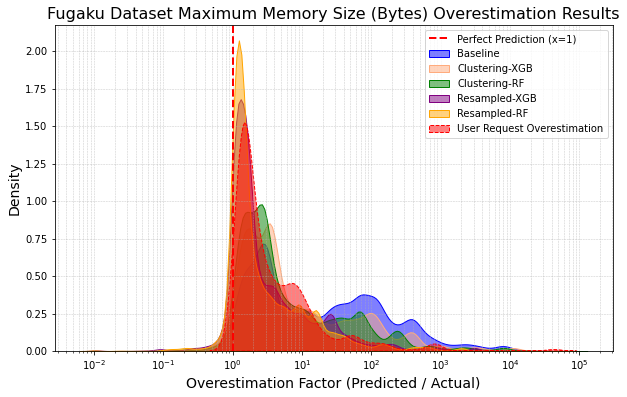

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define models and time range
models = ['baseline', 'clustering_xgb', 'clustering_rf', 'resampled_xgb', 'resampled_rf']
start_dates = pd.date_range(start=start_time, end=end_time, freq='3D')

# Define model colors and labels
model_colors = {
    'baseline': 'blue',
    'clustering_xgb': '#FFAB7D',
    'clustering_rf': 'green',
    'resampled_xgb': 'purple',
    'resampled_rf': 'orange'
}
custom_labels = {
    'baseline': 'Baseline',
    'clustering_xgb': 'Clustering-XGB',
    'clustering_rf': 'Clustering-RF',
    'resampled_xgb': 'Resampled-XGB',
    'resampled_rf': 'Resampled-RF'
}


data_list = []

for model in models:
    for start_date in start_dates:
        df = results[start_date].get(3, {}).get(model, {}).get('two_sigma')
        if df is None:
            continue
        
        df = df.copy()
        df['overestimation_factor'] = df['pred'] / df['act']
        df['user_overestimation_factor'] = df['req'] / df['act']
        
        model_data = pd.DataFrame({
            'overestimation_factor': df['overestimation_factor'],
            'model': model
        })
        data_list.append(model_data)

overestimation_df = pd.concat(data_list, ignore_index=True)

plt.figure(figsize=(10, 6))

for model in models:
    model_data = overestimation_df[overestimation_df['model'] == model]['overestimation_factor']
    sns.kdeplot(model_data, color=model_colors[model], label=custom_labels[model], log_scale=True, fill=True, alpha=0.5)

user_overestimation_data = df['user_overestimation_factor']
sns.kdeplot(user_overestimation_data, color='red', label='User Request Overestimation', log_scale=True, fill=True, alpha=0.5, linestyle='dashed')

plt.axvline(x=1, color='red', linestyle='dashed', linewidth=2, label='Perfect Prediction (x=1)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


plt.xlabel('Overestimation Factor (Predicted / Actual)',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.title('Fugaku Dataset Maximum Memory Size (Bytes) Overestimation Results', fontsize=16)
plt.legend()
plt.show()




In [10]:
plot_data = []

for start_date, window_dict in results.items():
    for window_size, model_dict in window_dict.items():
        for model, bias_dict in model_dict.items():
            for bias, df in bias_dict.items():
                if df is not None and 'pred' in df.columns and 'act' in df.columns:
                
                    rmse = np.sqrt(np.mean((df['pred'] - df['act']) ** 2))
                    mae = np.mean(np.abs(df['pred'] - df['act']))

                    underpredictions = df[df['pred'] < df['act']]
                    num_underpredictions = len(underpredictions)
                    total_predictions = len(df)
                    underpred_ratio = 100 * num_underpredictions / total_predictions

                    # Compute the mean and std dev of underprediction amounts
                    underpred_amounts = (underpredictions['act'] - underpredictions['pred'])
                    total_underpred_amount = underpred_amounts.sum() / 3600
                    mean_underpred_amount = underpred_amounts.mean() / 3600
                    std_underpred_amount = underpred_amounts.std() / 3600

                    plot_data.append({
                        'Window Size': window_size, 
                        'Model': model, 
                        'Bias': bias, 
                        'RMSE': rmse, 
                        'MAE': mae, 
                        'UR': underpred_ratio, 
                        'UR_total(hours)': total_underpred_amount,
                        'UR_mean(hours)': mean_underpred_amount, 
                        'UR_std(hours)': std_underpred_amount
                    })
                
                else:
                    print(f"  Skipping Model: {model} due to missing columns")

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)


average_metrics = plot_df.groupby(['Window Size', 'Model', 'Bias']).mean().reset_index()


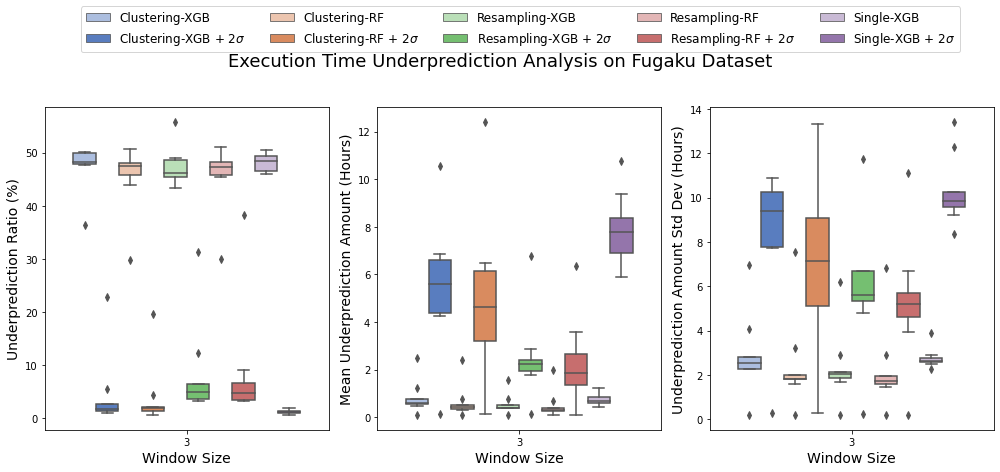

In [11]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

base_colors = sns.color_palette("muted", 5)

lighter_colors = [mcolors.to_rgb(c) for c in base_colors]
lighter_colors = [(r + 0.5*(1-r), g + 0.5*(1-g), b + 0.5*(1-b)) for r, g, b in lighter_colors]
custom_palette = [color for pair in zip(lighter_colors, base_colors) for color in pair]

plot_df["Model_Bias"] = plot_df["Model"] + " - " + plot_df["Bias"]

custom_labels = {
    'baseline - none': 'Single-XGB',
    'baseline - two_sigma': r'Single-XGB + $2\sigma$',
    'clustering_xgb - none': 'Clustering-XGB',
    'clustering_xgb - two_sigma': r'Clustering-XGB + $2\sigma$',
    'clustering_rf - none': 'Clustering-RF',
    'clustering_rf - two_sigma': r'Clustering-RF + $2\sigma$',
    'resampled_xgb - none': 'Resampling-XGB',
    'resampled_xgb - two_sigma': r'Resampling-XGB + $2\sigma$',
    'resampled_rf - none': 'Resampling-RF',
    'resampled_rf - two_sigma': r'Resampling-RF + $2\sigma$',
}

fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=True)

sns.boxplot(
    data=plot_df,   
    x="Window Size",   
    y="UR",    
    hue="Model_Bias",   
    palette=custom_palette,
    ax=axes[0]
)
axes[0].set_xlabel("Window Size", fontsize=14)
axes[0].set_ylabel("Underprediction Ratio (%)", fontsize=14)


sns.boxplot(
    data=plot_df,   
    x="Window Size",   
    y="UR_mean(hours)",    
    hue="Model_Bias",   
    palette=custom_palette,
    ax=axes[1]
)
axes[1].set_xlabel("Window Size", fontsize=14)
axes[1].set_ylabel("Mean Underprediction Amount (Hours)", fontsize=14)


sns.boxplot(
    data=plot_df,   
    x="Window Size",   
    y="UR_std(hours)",    
    hue="Model_Bias",   
    palette=custom_palette,
    ax=axes[2]
)
axes[2].set_xlabel("Window Size", fontsize=14)
axes[2].set_ylabel("Underprediction Amount Std Dev (Hours)", fontsize=14)



fig.suptitle("Execution Time Underprediction Analysis on Fugaku Dataset", fontsize=18)

handles, labels = axes[0].get_legend_handles_labels()

custom_labels_list = [custom_labels.get(label, label) for label in labels]

fig.legend(handles, custom_labels_list, loc='upper center', bbox_to_anchor=(0.52, 1.1), ncol=5, fontsize=12)

axes[0].legend_.remove()
axes[1].legend_.remove()
axes[2].legend_.remove()

plt.tight_layout(rect=[0, 0, 1, 0.95])

plot_name = 'boxplot_fugaku.svg'
file_path = os.path.join('/projectnb/peaclab-mon/boztop/resource-allocation/plots', plot_name)
plt.savefig(file_path, format="svg", dpi=300, bbox_inches='tight')

plt.show()


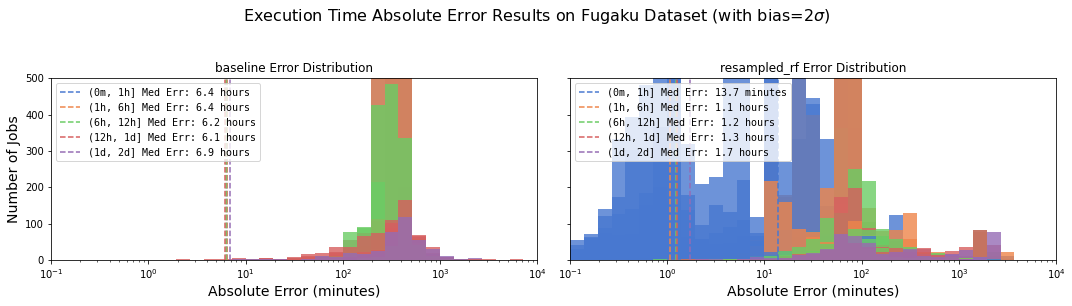

In [16]:
# Visualize underprediction distribution
start_dates = pd.date_range(start=start_time, end=end_time, freq='3D')

models = ['baseline',  'resampled_rf']
fig, axes = plt.subplots(1, len(models), figsize=(15, 4), sharey=True)

bounds = [0, 60*60, 60*60*6, 60*60*12, 60*60*24, 60*60*24*2]
colors = sns.color_palette("muted", len(bounds))
line_colors = colors.copy()


for ax, model in zip(axes, models):
    ax.set_title(f'{model} Error Distribution')
    median_errors = {bound: [] for bound in bounds[:-1]}  # Store median errors for each bin
    total_underpred = 0
    total_jobs = 0

    for start_date in start_dates:
        df = results[start_date].get(3, {}).get(model, {}).get('two_sigma')
        if df is None:
            continue
        df = df.copy()
        underpredictions = df[df['pred'] < df['act']].copy()
        df.loc[:, 'error'] = df['act'] - df['pred']
        df.loc[:, 'abs_error'] = abs(df['error'])
        
        for i, bound in enumerate(bounds[:-1]):
            l_bound = bound
            r_bound = bounds[i + 1]
            color = colors[i]
            line_color = line_colors[i]

            error_sample = df[df.act.between(l_bound, r_bound, inclusive='right')].abs_error / 60
            ax.hist(error_sample, bins=np.logspace(-3, 4, 50), color=color, alpha=0.8)

            med_err = error_sample.median()
            if not np.isnan(med_err):  # Store median error only if valid
                median_errors[bound].append(med_err)

    # Plot median error lines after processing all start dates
    for i, bound in enumerate(bounds[:-1]):
        if median_errors[bound]:  # If there are valid medians
            med_err_final = np.median(median_errors[bound])  # Take median of medians
            med_err_label = 'minutes'
            if med_err_final > 60:
                med_err_final /= 60
                med_err_label = 'hours'

            # Format bounds label
            bound_label = '('
            for bound in (bounds[i], bounds[i + 1]):
                if bound < 60*60:
                    new_bound = f"{bound//60}m"
                elif bound < 60*60*24:
                    new_bound = f"{bound//(60*60)}h"
                else:
                    new_bound = f"{bound//(24*60*60)}d"
                bound_label += f"{new_bound}, "
            bound_label = bound_label[:-2] + ']'

            ax.vlines(med_err_final, 0, 250000, linestyle='--', color=line_colors[i], 
                      label=f'{bound_label} Med Err: {med_err_final:.1f} {med_err_label}')
    
    ax.set_xscale('log')
    ax.set_xlim(0.1, 10000)
    ax.set_ylim([0, 500])
    ax.legend(loc='upper left', prop={'family': 'DejaVu Sans Mono'})
    ax.set_xlabel('Absolute Error (minutes)',fontsize=14)
    if ax == axes[0]:
        ax.set_ylabel('Number of Jobs',fontsize=14)

plt.suptitle(r'Execution Time Absolute Error Results on Fugaku Dataset (with bias=2$\sigma$)', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()
